In [1]:
# ================================
# STEP 0: Import Libraries
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

patient_info = pd.read_csv("patient_info.csv", delimiter=';') #patient information
patient_mean_df = pd.read_csv("patient_mean_df.csv")  # activity and HRV data, aggregated at the patient level
# ================================
# STEP 1: Merge Patient Info
# ================================
# Clean IDs
patient_info.rename(columns={"ID": "Patient ID"}, inplace=True)
patient_info['Patient ID'] = patient_info['Patient ID'].astype(int)
patient_mean_df['Patient ID'] = patient_mean_df['Patient ID'].apply(lambda x: int(str(x).split('_')[-1]))

# Merge on Patient ID
df = pd.merge(patient_mean_df, patient_info, on="Patient ID", how="inner")
df = df[df["ADHD"] == 1].reset_index(drop=True)
# ================================
# STEP 2: Define Features
# ================================
activity_features = [
    "ACTIVITY__variance_larger_than_standard_deviation",
    "ACTIVITY__number_peaks__n_1",
    "ACTIVITY__number_peaks__n_3",
    "ACTIVITY__number_peaks__n_5",
    "ACTIVITY__binned_entropy__max_bins_10"
]
hrv_features = ["SDNN", "RMSSD", "NN50", "pNN50", "LF", "HF","LF/HF"]
feature_cols = activity_features + hrv_features 

# ================================
# STEP 3: Scale Features
# ================================
X = df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

K = 2 → Silhouette = 0.409,  CH = 22.18
K = 3 → Silhouette = 0.377,  CH = 18.72
K = 4 → Silhouette = 0.348,  CH = 15.27
K = 5 → Silhouette = 0.344,  CH = 17.19


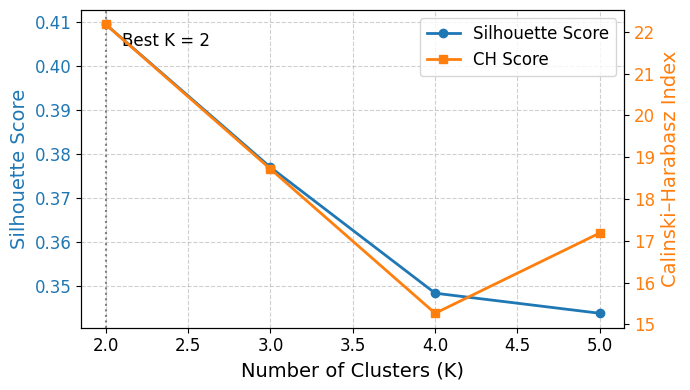

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# ================================
# STEP 1: Compute Scores
# ================================
k_range = range(2, 6)
silhouette_scores = {}
ch_scores = {}
kmeans_results = {}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    
    silhouette_scores[k] = sil
    ch_scores[k] = ch
    kmeans_results[f'KMeans_{k}'] = labels
    
    print(f"K = {k} → Silhouette = {sil:.3f},  CH = {ch:.2f}")

# Identify best K based on Silhouette Score
best_k = max(silhouette_scores, key=silhouette_scores.get)

# ================================
# STEP 2: Plot with Enhancements
# ================================
fig, ax1 = plt.subplots(figsize=(7, 4))

# Silhouette axis (left)
color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)', fontsize=14)
ax1.set_ylabel('Silhouette Score', color=color1, fontsize=14)
l1 = ax1.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()),
              marker='o', color=color1, label='Silhouette Score', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

# Add vertical line for best K
ax1.axvline(x=best_k, color='gray', linestyle=':', linewidth=1.5)
ax1.text(best_k + 0.1, max(silhouette_scores.values()) - 0.005,
         f'Best K = {best_k}', color='black', fontsize=12)

# CH axis (right)
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Calinski–Harabasz Index', color=color2, fontsize=14)
l2 = ax2.plot(list(ch_scores.keys()), list(ch_scores.values()),
              marker='s', color=color2, label='CH Score', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)

# Combine legends
lines = l1 + l2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=12)

# plt.title("Clustering Metrics vs. Number of Clusters (K)", fontsize=16)
fig.tight_layout()
# Save figure
image_path = "clustering_metrics_plot.png"
plt.savefig(image_path, dpi=300)
image_path
plt.show()

/var/folders/zc/wjk9yqxs64d2fvcqw0jvrdzw0000gn/T/ipykernel_34129/1394281595.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(


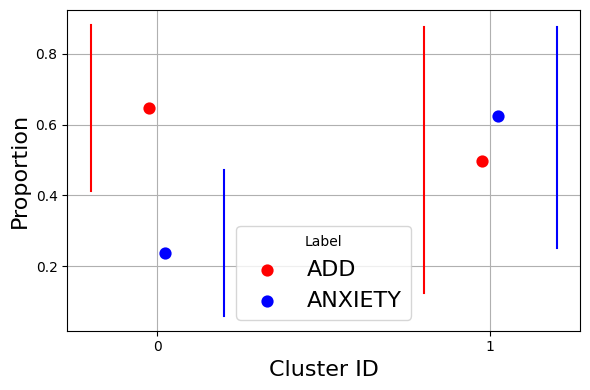


Bootstrapped Cluster Summary with 95% Confidence Intervals:
     Label  Cluster      Mean  CI_Lower  CI_Upper   N
0      ADD        0  0.645776  0.411765  0.882353  17
1      ADD        1  0.497563  0.125000  0.875000   8
2  ANXIETY        0  0.236006  0.058824  0.470588  17
3  ANXIETY        1  0.625425  0.250000  0.875000   8


In [17]:
### Use this
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.merge(patient_mean_df, patient_info, on="Patient ID", how="inner")
# ----------------------------
# Step 2: Filter for ADHD Diagnosed Participants
# ----------------------------
df = df[df["ADHD"] == 1].reset_index(drop=True)
# ----------------------------
# Step 3: Define Feature Sets
# ----------------------------
activity_features = [
    "ACTIVITY__variance_larger_than_standard_deviation",
    "ACTIVITY__number_peaks__n_1",
    "ACTIVITY__number_peaks__n_3",
    "ACTIVITY__number_peaks__n_5",
    "ACTIVITY__binned_entropy__max_bins_10"
]

hrv_features = ["SDNN", "RMSSD", "NN50", "pNN50", "LF", "HF","LF/HF"]
label_features = ["ADD", "ANXIETY"]  # ADHD excluded because all are ADHD
passive_features = activity_features + hrv_features 
# ----------------------------
# Step 4: Normalize Passive Features
# ----------------------------
X = df[passive_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# ----------------------------
# Step 5: Perform KMeans Clustering
# ----------------------------
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df["Cluster"] = kmeans.fit_predict(X_scaled)

# ----------------------------
# Step 6: Bootstrap 95% Confidence Intervals
# ----------------------------

def bootstrap_mean_ci(data, n_bootstrap=10000, ci=95,  method='BCa'):
    """Return bootstrap mean and CI for binary/categorical data"""
    boot_means = [np.mean(resample(data, replace=True)) for _ in range(n_bootstrap)]
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(boot_means), lower, upper

# Run bootstrapping for each diagnostic variable per cluster
results = []

for label in label_features:
    for cluster_id in sorted(df["Cluster"].unique()):
        values = df[df["Cluster"] == cluster_id][label].dropna()
        mean, lower, upper = bootstrap_mean_ci(values)
        results.append({
            "Label": label,
            "Cluster": cluster_id,
            "Mean": mean,
            "CI_Lower": lower,
            "CI_Upper": upper,
            "N": len(values)
        })

results_df = pd.DataFrame(results)

# ----------------------------
# Step 7: Visualization
# ----------------------------

plt.figure(figsize=(6, 4))
label_palette = {
    "ADD": "red",         # deep red
    "ANXIETY": "blue"    # strong blue
}

sns.pointplot(
    data=results_df,
    x='Cluster',
    y='Mean',
    hue='Label',
    dodge=True,
    join=False,
    ci=None,         # <-- important: disable Seaborn CI
    palette=label_palette
)

# Add bootstrapped error bars manually
dodge_offset = 0.2  # same as Seaborn's internal dodge value

for _, row in results_df.iterrows():
    x_pos = row["Cluster"] + (-dodge_offset if row["Label"] == "ADD" else dodge_offset)
    plt.plot([x_pos, x_pos], [row['CI_Lower'], row['CI_Upper']],
             color=label_palette[row['Label']], linewidth=1.5)

# Final plot settings
# plt.title("Bootstrapped Cluster-Wise Means with 95% CI (ADHD-Only Participants)",fontsize='16')
plt.ylabel("Proportion",fontsize='16')
plt.xlabel("Cluster ID",fontsize='16')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Label",fontsize='16',loc='lower center')
plt.savefig("Bootstrapped Cluster-Wise.png",
            dpi=300,             # dots per inch
            bbox_inches="tight"  # trim extra whitespace
           )
plt.show()
# ----------------------------
# Step 8: Show Results
# ----------------------------
# Print the bootstrapped results
print("\nBootstrapped Cluster Summary with 95% Confidence Intervals:")
print(results_df)

In [18]:
full_df=pd.merge(patient_mean_df, patient_info, on="Patient ID", how="inner")
# Get non-ADHD participants only
df_non_adhd = full_df[full_df["ADHD"] == 0].copy()

# Make sure only the required passive features are used
X_non_adhd = df_non_adhd[feature_cols]

# Apply same scaler (fit on ADHD)
X_non_adhd_scaled = scaler.transform(X_non_adhd)

# Predict cluster assignment using ADHD-trained model
df_non_adhd["Predicted_Cluster"] = kmeans.predict(X_non_adhd_scaled)

# Show results
print("\n🔍 Cluster Assignment for Non-ADHD Participants:")
print(df_non_adhd["Predicted_Cluster"].value_counts().sort_index())


🔍 Cluster Assignment for Non-ADHD Participants:
Predicted_Cluster
0    21
1     4
Name: count, dtype: int64


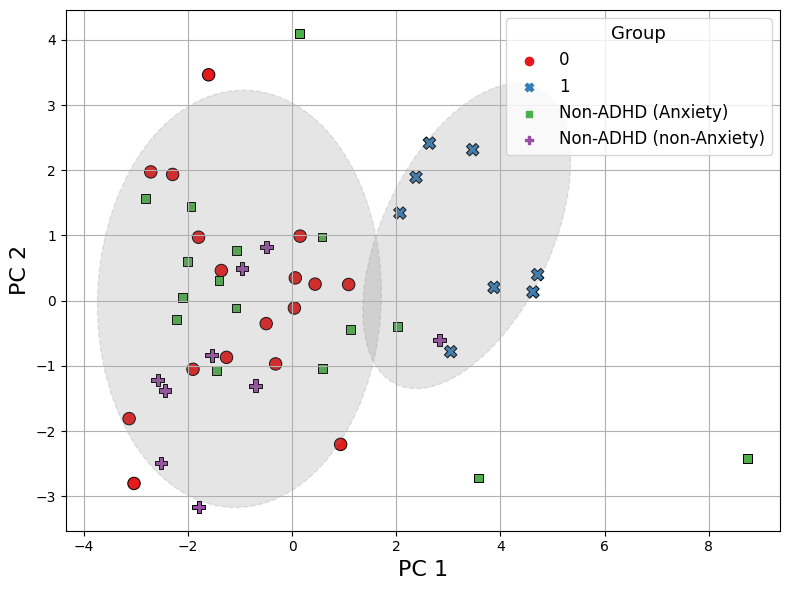

In [19]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Apply PCA on all participants (ADHD + non-ADHD)
X_all_combined = pd.concat([df[passive_features], df_non_adhd[passive_features]])
X_all_scaled = scaler.transform(X_all_combined)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

# Label groups
labels = list(df["Cluster"].astype(str)) + [
    "Non-ADHD (Anxiety)" if anx == 1 else "Non-ADHD (non-Anxiety)"
    for anx in df_non_adhd["ANXIETY"]
]
plot_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
plot_df["Group"] = labels

# Helper: draw ellipse around a cluster
def draw_ellipse(x, y, ax, **kwargs):
    if len(x) < 2:
        return  # skip if not enough points
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*4, height=lambda_[1]*4,
                  angle=np.rad2deg(np.arccos(v[0, 0])),
                  **kwargs)
    ax.add_patch(ell)

# Plotting
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=plot_df, x="PC1", y="PC2", hue="Group", style="Group",
    s=80, edgecolor="black", palette="Set1")

# Draw ellipses around ADHD clusters
for cluster_id in ['0', '1']:
    cluster_points = plot_df[plot_df["Group"] == cluster_id]
    draw_ellipse(cluster_points["PC1"], cluster_points["PC2"], ax=ax, alpha=0.2, color="gray", linestyle="--")

# Set title and axis labels with larger fonts
# plt.title("PCA: ADHD Clusters with Non-ADHD (Anxious) Overlay", fontsize=16)
plt.xlabel("PC 1", fontsize=16)
plt.ylabel("PC 2", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Group", loc='upper right', fontsize=12, title_fontsize=13)

# Save high-quality figure
plt.savefig("pca_clusters2.pdf", dpi=600, bbox_inches='tight')
plt.show()